<a href="https://colab.research.google.com/github/silvhua/Netflix-Recommender-Engines-Challenge/blob/main/recommender_engines_II_Exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab stuff

In [ ]:
# You can see what GPU you've been assigned at any time by executing the following cell
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# You can see how much memory you have available at any time by running the following code cell. 
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Dec 14 01:18:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/movie_titles.csv', header=None, 
    encoding = "ISO-8859-1", # As per https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation
    usecols=[0, 1, 2], # Required because some movie titles (column 2) have commas, causing parser error otherwise
    names=['Movie_Id', 'Year', 'Name'])
movies.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [ ]:
# Load all ratings data
df1 = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_1.txt', header=None, names=['Customer', 'Rating', 'Date'], usecols = [0,1,2])
df2 = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_2.txt', header=None, names=['Customer', 'Rating', 'Date'], usecols = [0,1,2])
df3 = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_3.txt', header=None, names=['Customer', 'Rating', 'Date'], usecols = [0,1,2])
df4 = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_4.txt', header=None, names=['Customer', 'Rating', 'Date'], usecols = [0,1,2])

In [ ]:
# Used this as an example: https://www.kaggle.com/code/morrisb/how-to-recommend-anything-deep-recommender
from collections import deque 
def reshape_df(df):
    tmp_movies = df[df['Rating'].isna()]['Customer'].reset_index()
    movie_index = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

    # Shift the movie_indices by one to get start and endpoints of all movies
    shifted_movie_index = deque(movie_index)
    shifted_movie_index.rotate(-1)
    user_data = []
    for [df_id1, movie_id1], [df_id2, movie_id2] in zip(movie_index, shifted_movie_index):
        # check if last movie in the file
        if df_id1 < df_id2:
            tmp_df = df.loc[df_id1+1: df_id2-1].copy()
        else:
            tmp_df = df.loc[df_id1+1:].copy()
        # create movie_id column
        tmp_df['Movie_ID'] = movie_id1
        user_data.append(tmp_df)
    df2 = pd.concat(user_data)
    del user_data, df, tmp_df
    print('Shape:', df2.shape)
    return df2


In [ ]:
# Create a single dataframe with all the ratings
df = pd.concat([df1, df2, df3, df4]).reset_index(drop=True)

In [ ]:
# reshape the dataframe
df0 = reshape_df(df)
df0.to_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_reshaped.csv')
del df1, df2, df3, df4

## Load processed CSV

In [3]:
import pandas as pd
import numpy as np

def load_csv(filename,filepath,column1_as_index=False,truncate=None, usecols=None, sep=','):
    """
    Load a csv file as a dataframe using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    - colum1_as_index (bool): If true, take the first column as the index. 
        Useful when importing CSV files from previously exported dataframes.

    Returns: dataframe object.
    """
    filename = f'{filepath}/'.replace('\\','/')+filename
    df = pd.read_csv(filename, usecols=usecols, sep=sep)
    if column1_as_index==True:
        df.set_index(df.columns[0], inplace=True)
        df.index.name = None
    print('Dataframe shape: ',df.shape)

    if truncate:
        return df.sample(n=truncate,random_state=0)
    else:
        return df

df0 = load_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_reshaped.csv',filepath='',
               column1_as_index=True)
df0.head()

Dataframe shape:  (100480507, 4)


,Customer,Rating,Date,Movie_ID
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


In [4]:
df0['Rating'].describe()

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

# Plan
1. Predict Ratings
  *   Surprise algorithms with and without hyperparameter tuning
    * SVD
    * SVDpp
    * NMF
  * Linear regression
  * SVD plus bias with different `n_component` values

2. Make recommendations using the best estimator

# Scikit Surprise with Train-Test Split

In [ ]:
! pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 771 kB 26.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626452 sha256=7c26af75edaa9da843f3a81a829e2e3e583023a7a5d4b527abcb5b271873f698
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [ ]:
# # import dataset from surprise
from surprise import Dataset
from surprise import Reader

# Create data set in surprise format
reader = Reader(rating_scale=(1, 5))
# Loads Pandas dataframe
data = Dataset.load_from_df(df0[['Customer', 'Movie_ID', 'Rating']], reader)

In [ ]:
from surprise.model_selection import train_test_split
# Train test split
trainset, testset = train_test_split(data, test_size=.15)
del data

In [ ]:
# Save trainset and test set
import pickle
with open('/content/drive/MyDrive/data exercises/W10/netflix-challenge/surprise_trainset.pickle', 'wb') as fh:
  pickle.dump(trainset, fh)
with open('/content/drive/MyDrive/data exercises/W10/netflix-challenge/surprise_testset.pickle', 'wb') as fh2:
  pickle.dump(testset, fh2)

## `surprise_predictions` function and SVD algorithm

In [ ]:
# import SVD from surprise
from surprise import SVD

# import accuracy from surprise
from surprise import accuracy

# import GridSearchCV from surprise.model_selection
from surprise.model_selection import GridSearchCV
# import cross_validate from surprise.model_selection
from surprise.model_selection import cross_validate


def surprise_gridsearch_predictions(estimator, param_grid, data, pickle_name=None):
  """
  Perform gridsearch with surprise data set.
  """
  gs = GridSearchCV(estimator, param_grid, measures={'rmse'})
  gs.fit(data)
  print('Best grid search parameters:', gs.best_params['rmse'])
  predictions = gs.test(testset)
  rmse = accuracy.rmse(predictions)
  print(f'Model RMSE: {rmse:.2f}')
  filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
  if pickle:
    with open(filepath+pickle_name+'_model.pickle', 'wb') as fh:
      pickle.dump(gs.best_estimator_, fh)
    with open(filepath+pickle_name+'_predictions.pickle', 'wb') as fh2:
      pickle.dump(predictions, fh)
  return gs.best_estimator_, predictions

  
def surprise_predictions(algorithm, trainset=trainset, testset=testset, pickle_name=None):
  output = algorithm.fit(trainset)
  predictions = algorithm.test(testset)
  rmse = accuracy.rmse(predictions)
  print(f'Model RMSE: {rmse:.2f}')
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_model.pickle', 'wb') as fh:
        pickle.dump(algorithm, fh)
      with open(filepath+pickle_name+'_predictions.pickle', 'wb') as fh2:
        pickle.dump(predictions, fh)
      print(f'Saved: {filepath+pickle_name}_model.pickle')
      print(f'Saved: {filepath+pickle_name}_predictions.pickle')
    except:
      print('Outputs not saved')
    return algorithm, predictions


model_svd, predictions_svd = surprise_predictions(SVD(), pickle_name='surpriseSVD')

RMSE: 0.8333
Model RMSE: 0.83
Outputs not saved


In [ ]:
import pickle
filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
pickle_name='surpriseSVD'
with open(filepath+pickle_name+'_model.pickle', 'wb') as fh:
  pickle.dump(model_svd, fh)


In [ ]:
with open(filepath+pickle_name+'_predictions.pickle', 'wb') as fh2:
  pickle.dump(predictions_svd, fh2)
print(f'Saved: {filepath+pickle_name}_predictions.pickle')

Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/surpriseSVD_predictions.pickle


In [ ]:
param_grid = {
    'n_factors': [75, 100, 125],
    'lr_all': [0.005, 0.01],
}

## SVDpp algorithm

In [ ]:

from surprise import SVDpp
model_svdpp, predictions_svdpp = surprise_predictions(SVDpp(), pickle_name='surpriseSVDpp')
# Not sure why, but after 8 h 37 min using Google Colab Pro+ with Premium GPU, got an error saying that cell execution failed

## NMF

In [ ]:
! pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 771 kB 4.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626486 sha256=ff4a9e4ddf15b2e32f3ceb791df029afc26c80e7986bb9d6876151d1e071b98a
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [ ]:
import pickle
def savepickle(model,filename, ext='sav', path='/content/drive/MyDrive/data exercises/W10/netflix-challenge/',append_version=False):
    """
    Export object as a pickle.
    Parameters:
    - model: Model variable name.
    - filename: Root of the filename.
    - extension: Extension to append (do not include dot as it will be added)
    - filepath (raw string): Use the format r'<path>'. If None, file is saved in same director.
    - append_version (bool): If true, append date and time to end of filename.
    """
    if path:
        path = f'{path}/'.replace('\\','/')
    if append_version == True:
        filename+=datetime.now().strftime('%Y-%m-%d_%H%M')
    with open (path+filename+'.'+ext, 'wb') as fh:
        pickle.dump(model, fh)
    print('File saved: ',path+filename+'.'+ext)

def loadpickle(filename,filepath='/content/drive/MyDrive/data exercises/W10/netflix-challenge/'):
    """
    Load a pickled model using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    
    Returns saved object.
    """
    filename = filepath+filename
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

trainset = loadpickle('surprise_trainset.pickle')


In [ ]:
testset = loadpickle('surprise_testset.pickle',filepath=r'/content/drive/MyDrive/data exercises/W10/netflix-challenge/')

In [ ]:
from surprise import accuracy
def surprise_predictions(algorithm, trainset=trainset, testset=testset, pickle_name=None):
  output = algorithm.fit(trainset)
  predictions = algorithm.test(testset)
  rmse = accuracy.rmse(predictions)
  print(f'Model RMSE: {rmse:.2f}')
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_model.pickle', 'wb') as fh:
        pickle.dump(algorithm, fh)
      print(f'Saved: {filepath+pickle_name}_model.pickle')
      with open(filepath+pickle_name+'_predictions.pickle', 'wb') as fh2:
        pickle.dump(predictions, fh2)
      print(f'Saved: {filepath+pickle_name}_predictions.pickle')
    except:
      print('Outputs not saved')
    return algorithm, predictions

In [ ]:
from surprise import NMF
model_NMF, predictions_NMF = surprise_predictions(NMF(), pickle_name='surpriseNMF')

RMSE: 0.9256
Model RMSE: 0.93
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/surpriseNMF_model.pickle
Outputs not saved


### Make recommendations

In [ ]:
import pandas as pd
import numpy as np
import pickle

def loadpickle(filename,filepath='/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'):
    """
    Load a pickled model using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    
    Returns saved object.
    """
    filename = filepath+filename
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model


surpriseNMF_model = loadpickle('surpriseNMF_model.pickle', filepath=r'/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/')

In [ ]:
from surprise import accuracy
# from surprise import mae
def surprise_test_predictions(algorithm, testset=testset, pickle_name=None):
  predictions = algorithm.test(testset)
  rmse = accuracy.rmse(predictions)
  mae = accuracy.mae(predictions)
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_model.pickle', 'wb') as fh:
        pickle.dump(algorithm, fh)
      print(f'Saved: {filepath+pickle_name}_model.pickle')
      with open(filepath+pickle_name+'_predictions.pickle', 'wb') as fh2:
        pickle.dump(predictions, fh2)
      print(f'Saved: {filepath+pickle_name}_predictions.pickle')
    except:
      print('Outputs not saved')
  return predictions

surpriseNMF_predictions = surprise_test_predictions(surpriseNMF_model)

RMSE: 0.9256
MAE:  0.7255


In [ ]:
surpriseNMF_predictions

[Prediction(uid=1710493, iid=10143, r_ui=5.0, est=4.229726344327675, details={'was_impossible': False}),
 Prediction(uid=2613674, iid=17321, r_ui=5.0, est=3.7816116084854574, details={'was_impossible': False}),
 Prediction(uid=2250563, iid=148, r_ui=4.0, est=3.4058416863409753, details={'was_impossible': False}),
 Prediction(uid=1086028, iid=11701, r_ui=4.0, est=3.198165478313749, details={'was_impossible': False}),
 Prediction(uid=1146055, iid=10550, r_ui=3.0, est=4.013417641879125, details={'was_impossible': False}),
 Prediction(uid=950251, iid=15373, r_ui=4.0, est=3.4500971515612266, details={'was_impossible': False}),
 Prediction(uid=2304083, iid=2660, r_ui=5.0, est=4.502897508763667, details={'was_impossible': False}),
 Prediction(uid=1022657, iid=16357, r_ui=2.0, est=3.5159693594546613, details={'was_impossible': False}),
 Prediction(uid=1942584, iid=15058, r_ui=4.0, est=3.5559743352383064, details={'was_impossible': False}),
 Prediction(uid=1344227, iid=6283, r_ui=1.0, est=3.092

In [ ]:
def load_csv(filename,filepath,column1_as_index=False,truncate=None, usecols=None, sep=','):
    """
    Load a csv file as a dataframe using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    - colum1_as_index (bool): If true, take the first column as the index. 
        Useful when importing CSV files from previously exported dataframes.

    Returns: dataframe object.
    """
    filename = f'{filepath}/'.replace('\\','/')+filename
    df = pd.read_csv(filename, usecols=usecols, sep=sep)
    if column1_as_index==True:
        df.set_index(df.columns[0], inplace=True)
        df.index.name = None
    print('Dataframe shape: ',df.shape)

    if truncate:
        return df.truncate(after=truncate)
    else:
        return df

# load first ratings data set
df1 = load_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_reshaped.csv',filepath='',
               column1_as_index=True).truncate(after=24053764)

Dataframe shape:  (100480507, 4)


In [ ]:
df0 = load_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_reshaped.csv',filepath='',
               column1_as_index=True)

Dataframe shape:  (100480507, 4)


In [ ]:
def recommend_movie(customer_id, model, ratings=df0, movies=movies):
  """2022-12-05 19:36
  Recommend 1 movie for a given customer.
  Parameters:
    - customer_id: Customer_id
    - model: A surprise model that has been fit.
    - ratings: DataFrame containing all customer ratings.
    - movies: DataFrame containing Movie_Id and title.

  """
  rated = ratings.loc[ratings['Customer']==customer_id, 'Movie_ID'].values
  unrated = np.setdiff1d(movies['Movie_Id'], rated)
  testset = [[customer_id, movie, 1] for movie in unrated]
  predictions = model.test(testset)
  predicted_ratings = np.array([pred.est for pred in predictions])
  recommendation_index = predicted_ratings.argmax()
  recommendation_movie_id = unrated[recommendation_index]
  recommendation = movies.loc[movies['Movie_Id']==recommendation_movie_id, 'Name'].values
  return recommendation


def batch_recommend(customers_df, model, movies=movies):
  recommendations = pd.DataFrame(index=customers_df.index)
  rated_movie = [movies[movies['Movie_Id'] == id]['Name'].values[0] for id in customers_df['Movie_ID'].values]
  recommendations['Rated Movie'] = rated_movie
  recommendations['Recommended Movie'] = customers_df['Customer'].apply(lambda x: recommend_movie(x, model))
  recommendations.index.name = 'Customer'
  print(f"**Input movies count**: {len(recommendations['Rated Movie'].value_counts())}\n{recommendations['Rated Movie'].value_counts()}")
  print(f"\n**Recommended movies count**: {len(recommendations['Recommended Movie'].value_counts())}\n{recommendations['Recommended Movie'].value_counts()}")
  print(f"\n**No recommendations count**: {recommendations['Recommended Movie'].isna().sum()}")
  return recommendations

In [ ]:
df1.columns

Index(['Customer', 'Rating', 'Date', 'Movie_ID'], dtype='object')

In [ ]:
batch_recommend(df1.sample(100, random_state=0), model=surpriseNMF_model)

**Input movies count**: 87
Braveheart                                                3
Pirates of the Caribbean: The Curse of the Black Pearl    3
Beverly Hills Cop                                         2
The Italian Job                                           2
Jurassic Park III                                         2
                                                         ..
Lethal Weapon 3                                           1
AcceleRacers                                              1
The Devil's Backbone                                      1
What Women Want                                           1
Teen Wolf / Teen Wolf Too (Double Feature)                1
Name: Rated Movie, Length: 87, dtype: int64

**Recommended movies count**: 29
[Trailer Park Boys: Season 3]                                                    27
[Veronica Mars: Season 1]                                                        10
[Lord of the Rings: The Return of the King: Extended Edition]      

,Rated Movie,Recommended Movie
Customer,,
20919541,End of Days,[Lord of the Rings: The Return of the King: Ex...
9374412,Samurai Trilogy 3: Duel at Ganryu Island,[Family Guy: Freakin' Sweet Collection]
12755785,Lord of the Rings: The Fellowship of the Ring,[Trailer Park Boys: Season 3]
14829972,The Silence of the Lambs,[Trailer Park Boys: Season 3]
7247996,Belly of the Beast,[As Time Goes By: Series 8]
...,...,...
16503635,Around the World in 80 Days,[Character]
18714930,The Wizard of Oz: Collector's Edition,[Ken Burns' Civil War]
12201510,To Catch a Thief,[Battlestar Galactica: Season 1]


# Surprise: trained and evaluated on whole trainset

In [ ]:
import pandas as pd
import numpy as np

def load_csv(filename,filepath,column1_as_index=False,truncate=None, usecols=None, sep=','):
    """
    Load a csv file as a dataframe using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    - colum1_as_index (bool): If true, take the first column as the index. 
        Useful when importing CSV files from previously exported dataframes.

    Returns: dataframe object.
    """
    filename = f'{filepath}/'.replace('\\','/')+filename
    df = pd.read_csv(filename, usecols=usecols, sep=sep)
    if column1_as_index==True:
        df.set_index(df.columns[0], inplace=True)
        df.index.name = None
    print('Dataframe shape: ',df.shape)

    if truncate:
        return df.truncate(after=truncate)
    else:
        return df
        
df0 = load_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_reshaped.csv',filepath='',
               column1_as_index=True, truncate=1000000)

Dataframe shape:  (100480507, 4)


In [ ]:
df0

,Customer,Rating,Date,Movie_ID
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1
...,...,...,...,...
999996,528854,5.0,2005-02-21,225
999997,962705,3.0,2005-02-22,225
999998,1299323,2.0,2005-02-24,225
999999,2026970,4.0,2005-02-27,225


In [ ]:
import pickle
def savepickle(model,filename, ext='sav', path='/content/drive/MyDrive/data exercises/W10/netflix-challenge/',append_version=False):
    """
    Export object as a pickle.
    Parameters:
    - model: Model variable name.
    - filename: Root of the filename.
    - extension: Extension to append (do not include dot as it will be added)
    - filepath (raw string): Use the format r'<path>'. If None, file is saved in same director.
    - append_version (bool): If true, append date and time to end of filename.
    """
    if path:
        path = f'{path}/'.replace('\\','/')
    if append_version == True:
        filename+=datetime.now().strftime('%Y-%m-%d_%H%M')
    with open (path+filename+'.'+ext, 'wb') as fh:
        pickle.dump(model, fh)
    print('File saved: ',path+filename+'.'+ext)

def create_full_trainset(df0, pickle_name=None):
  """
  Create trainset (truncated) without train_test_split
  """
  from surprise import Dataset, Reader
  print('Input DataFrame shape: ', df0.shape)

  # Create data set in surprise format
  reader = Reader(rating_scale=(1, 5))
  # Loads Pandas dataframe
  data = Dataset.load_from_df(df0[['Customer', 'Movie_ID', 'Rating']], reader)
  full_trainset = data.build_full_trainset()
  if pickle:
    savepickle(full_trainset, pickle_name)
    savepickle(data, pickle_name+'_data')
  return full_trainset, data

full_trainset, data = create_full_trainset(df0, pickle_name='surprise_full_trainset')

Input DataFrame shape:  (999776, 4)
File saved:  /content/drive/MyDrive/data exercises/W10/netflix-challenge//surprise_full_trainset.sav
File saved:  /content/drive/MyDrive/data exercises/W10/netflix-challenge//surprise_full_trainset_data.sav


## NMF

In [ ]:
# import cross_validate from surprise.model_selection
from surprise.model_selection import cross_validate, KFold
from surprise import accuracy
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import StratifiedKFold
def surprise_modelling(algorithm, input_ratings=df0, data=data, trainset=full_trainset, only_plot=False, 
                       pickle_name=None, context='talk'):
  """2022-12-21 1:09 make more efficient
  Train a model entire trainset and evaluate with cross-validation.
  """
  sns.reset_defaults()    
  %matplotlib inline
  font_scale=1.4 if context=='talk' else 1
  rc={'lines.markersize': 6} if context=='talk' else None
  sns.set_theme(context=context, style='ticks', font_scale=font_scale, 
      rc=rc)
  if only_plot==False:
    # Run 5-fold cross-validation and print results
    try:
      r2_list = []
      rmse_list = []
      mae_list = []
      kf = KFold(n_splits=5)
      algorithm2 = algorithm
      for trainset_cv, testset in kf.split(data):
        output = algorithm2.fit(trainset_cv)
        cv_predictions = algorithm2.test(testset)
        cv_predicted_ratings = np.array([pred.est for pred in cv_predictions])
        cv_true_ratings = np.array([pred.r_ui for pred in cv_predictions])
        r2_list.append(r2_score(cv_true_ratings, cv_predicted_ratings))
        rmse_list.append(mean_squared_error(cv_true_ratings, cv_predicted_ratings, squared=False))
        mae_list.append(mean_absolute_error(cv_true_ratings, cv_predicted_ratings))
        
      cv_r2 = np.mean(r2_list)
      cv_rmse = np.mean(rmse_list)
      cv_mae = np.mean(mae_list)
      print(f'Cross-validated RMSE: {cv_rmse:.4f}' )
      print(f'Cross-validated MAE: {cv_mae:.4f}')
      print(f'Cross-validated R^2: {cv_r2:.4f}')
      cv_results = pd.DataFrame([r2_list, rmse_list, mae_list], 
        columns=['R2', 'rmse', 'mae'], axis=1)
    except:
      cv_results = []
    algorithm.fit(trainset)
  else:
    cv_results = []
  customers = input_ratings['Customer'].values
  rated_movies = input_ratings['Movie_ID'].values

  # Predict ratings for all inputs
  testset = [[customer, movie, 1] for customer, movie in zip(customers, rated_movies)]
  predictions = algorithm.test(testset)
  predicted_ratings = np.array([pred.est for pred in predictions])
  input_ratings['model_predictions'] = predicted_ratings
  y = input_ratings['Rating']
  
  # Plot results 
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
  ax = ax.flatten()
  # Plot measured vs. predicted values for each model
  sns.lineplot(x=np.arange(0,5,1), y=np.arange(1,6,1), ax=ax[2], linewidth=0.8, color='orange',
      alpha=0.5)
  sns.violinplot(x=y, y=predicted_ratings, ax=ax[2]).set(xlabel='Actual Rating', ylabel='Predicted Rating')
  
  fig.suptitle(pickle_name)
  fig.tight_layout(rect=[0, 0, 1, 0.98])

  # Plot histogram of target values and independent variable
  sns.countplot(x=y, ax=ax[0])
  sns.histplot(x=input_ratings['model_predictions'], binwidth=1, ax=ax[1], discrete=True)
  
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_full_trainset_model.pickle', 'wb') as fh:
        pickle.dump(algorithm, fh)
      print(f'Saved: {filepath+pickle_name}_full_trainset_model.pickle')
      fig.savefig(filepath+pickle_name+'_results.png')
      print(f'Saved: {filepath+pickle_name}_results.png')
      if len(cv_results) > 0:
        with open(filepath+pickle_name+'_cv_results.pickle', 'wb') as fh2:
          pickle.dump(cv_results, fh2)
        print(f'Saved: {filepath+pickle_name}_cv_results.pickle')
      input_ratings.to_csv(filepath+pickle_name+'_predictions.csv')
      print(f'Saved: {filepath+pickle_name}_predictions.csv')
    except:
      print('Outputs not saved')
  return algorithm, cv_results, input_ratings

Cross-validated RMSE: 1.1468
Cross-validated MAE: 0.9086
Cross-validated R^2: -0.1381
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/surprise_NMF_full_trainset_model.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/surprise_NMF_results.png
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/surprise_NMF_predictions.csv


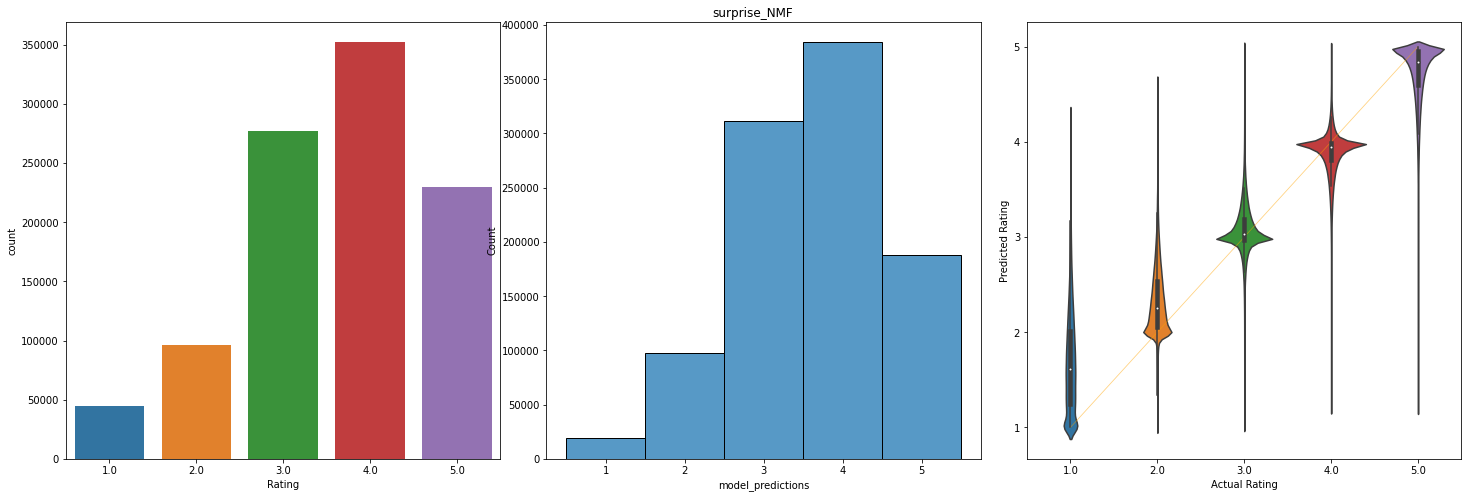

In [ ]:
from surprise import NMF
model_nmf2, cv_results_nmf, predictions_nmf2 = surprise_modelling(NMF(random_state=0), pickle_name='surprise_NMF')


### Re-do the figure above with bigger font

In [ ]:
import pandas as pd
import numpy as np
import pickle

def loadpickle(filename,filepath='/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'):
    """
    Load a pickled model using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    
    Returns saved object.
    """
    filename = filepath+filename
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [ ]:
model_nmf2 = loadpickle('surprise_NMF_full_trainset_model.pickle',
                        filepath=r'/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/')

Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/surprise_NMF_1221_full_trainset_model.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/surprise_NMF_1221_results.png
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/surprise_NMF_1221_predictions.csv


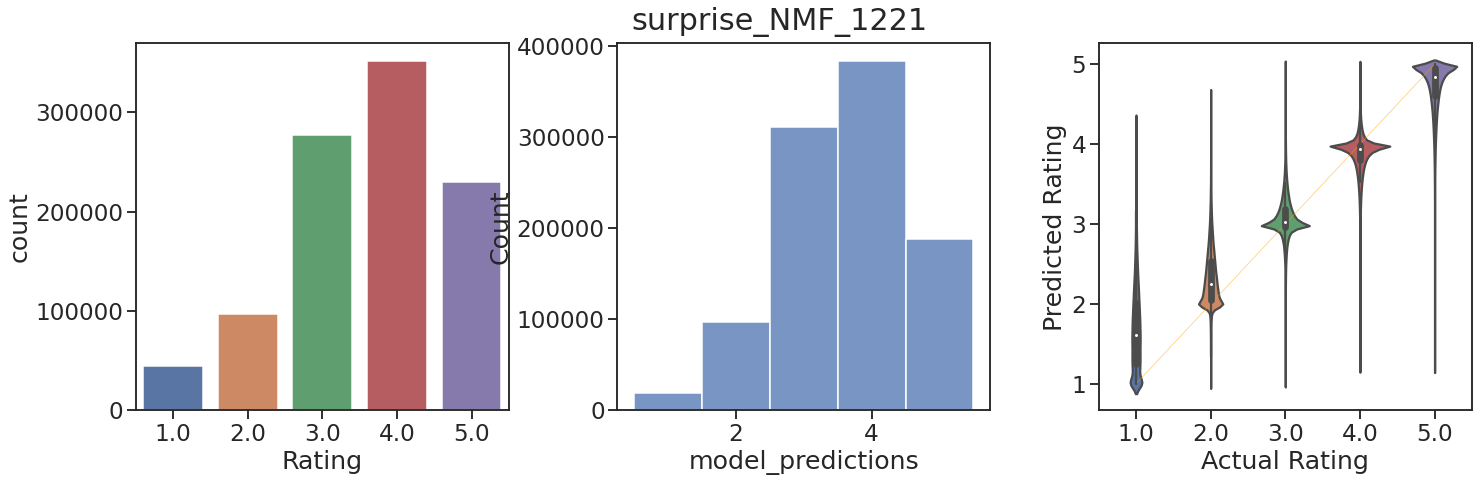

In [ ]:
model_nmf2, cv_results_nmf, predictions_nmf2 = surprise_modelling(model_nmf2, pickle_name='surprise_NMF_1221', only_plot=True)

### Make Recommendations

In [ ]:
def recommend_movie(customer_id, model, ratings=df0, movies=movies):
  """2022-12-05 19:36
  Recommend 1 movie for a given customer.
  Parameters:
    - customer_id: Customer_id
    - model: A surprise model that has been fit.
    - ratings: DataFrame containing all customer ratings.
    - movies: DataFrame containing Movie_Id and title.

  """
  rated = ratings.loc[ratings['Customer']==customer_id, 'Movie_ID'].values
  unrated = np.setdiff1d(movies['Movie_Id'], rated)
  testset = [[customer_id, movie, 1] for movie in unrated]
  predictions = model.test(testset)
  predicted_ratings = np.array([pred.est for pred in predictions])
  recommendation_index = predicted_ratings.argmax()
  recommendation_movie_id = unrated[recommendation_index]
  recommendation = movies.loc[movies['Movie_Id']==recommendation_movie_id, 'Name'].values
  return recommendation


def batch_recommend(customers_df, model, movies=movies):
  recommendations = pd.DataFrame(index=customers_df.index)
  rated_movie = [movies[movies['Movie_Id'] == id]['Name'].values[0] for id in customers_df['Movie_ID'].values]
  recommendations['Rated Movie'] = rated_movie
  recommendations['Recommended Movie'] = customers_df['Customer'].apply(lambda x: recommend_movie(x, model))
  recommendations.index.name = 'Customer'
  print(f"**Input movies count**: {len(recommendations['Rated Movie'].value_counts())}\n{recommendations['Rated Movie'].value_counts()}")
  print(f"\n**Recommended movies count**: {len(recommendations['Recommended Movie'].value_counts())}\n{recommendations['Recommended Movie'].value_counts()}")
  print(f"\n**No recommendations count**: {recommendations['Recommended Movie'].isna().sum()}")
  return recommendations



In [ ]:
batch_recommend(df0.sample(100, random_state=0), model=model_nmf2)

**Input movies count**: 31
Something's Gotta Give                     16
Reservoir Dogs                             16
X2: X-Men United                           12
Taking Lives                                9
Lilo and Stitch                             6
Chappelle's Show: Season 1                  4
Sweet November                              4
Duplex (Widescreen)                         3
Dragonheart                                 3
The Game                                    3
Congo                                       2
Death to Smoochy                            2
Richard III                                 2
A Little Princess                           1
That '70s Show: Season 1                    1
Richard Pryor: Live on the Sunset Strip     1
Spartan                                     1
Rudolph the Red-Nosed Reindeer              1
Rambo: First Blood Part II                  1
Invader Zim                                 1
G3: Live in Concert                         1
Maya Li

,Rated Movie,Recommended Movie
Customer,,
284858,Maya Lin: A Strong Clear Vision,[Henry: Portrait of a Serial Killer 2]
974510,Chappelle's Show: Season 1,[Lord of the Rings: The Return of the King: Ex...
74606,Lilo and Stitch,[Dinosaur Planet]
718703,X2: X-Men United,[ABC Primetime: Mel Gibson's The Passion of th...
273212,Dragonheart,[Stevie Ray Vaughan and Double Trouble: Live a...
...,...,...
654879,Reservoir Dogs,[Sanford and Son: Season 6]
865475,Taking Lives,[Lord of the Rings: The Return of the King: Ex...
282179,Invader Zim,[Lord of the Rings: The Return of the King: Ex...


## SVD

In [ ]:
import pickle
def savepickle(model,filename, ext='sav', path='/content/drive/MyDrive/data exercises/W10/netflix-challenge/',append_version=False):
    """
    Export object as a pickle.
    Parameters:
    - model: Model variable name.
    - filename: Root of the filename.
    - extension: Extension to append (do not include dot as it will be added)
    - filepath (raw string): Use the format r'<path>'. If None, file is saved in same director.
    - append_version (bool): If true, append date and time to end of filename.
    """
    if path:
        path = f'{path}/'.replace('\\','/')
    if append_version == True:
        filename+=datetime.now().strftime('%Y-%m-%d_%H%M')
    with open (path+filename+'.'+ext, 'wb') as fh:
        pickle.dump(model, fh)
    print('File saved: ',path+filename+'.'+ext)

def loadpickle(filename,filepath='/content/drive/MyDrive/data exercises/W10/netflix-challenge/'):
    """
    Load a pickled model using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    
    Returns saved object.
    """
    filename = filepath+filename
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model
    
path = r'/content/drive/MyDrive/data exercises/W10/netflix-challenge/'
full_trainset = loadpickle('surprise_full_trainset.sav', filepath=path)
data = loadpickle('surprise_full_trainset_data.sav', filepath=path)

Cross-validated RMSE: 0.9858
Cross-validated MAE: 0.7748
Cross-validated R^2: 0.1591
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/surprise_SVD_full_trainset_model.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/surprise_SVD_results.png
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/surprise_SVD_predictions.csv


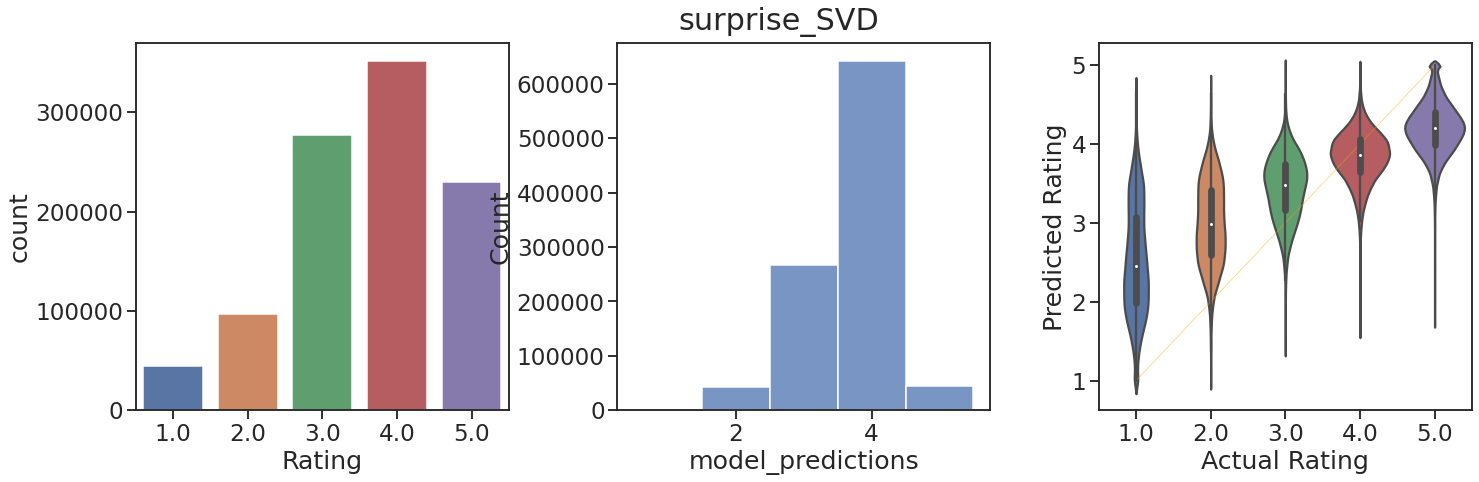

In [ ]:
from surprise import SVD
model_svd2, cv_results_svd, predictions_svd2 = surprise_modelling(SVD(random_state=0), pickle_name='surprise_SVD')

In [ ]:
batch_recommend(df0.sample(100, random_state=0), model=model_svd2)

**Input movies count**: 31
Something's Gotta Give                     16
Reservoir Dogs                             16
X2: X-Men United                           12
Taking Lives                                9
Lilo and Stitch                             6
Chappelle's Show: Season 1                  4
Sweet November                              4
Duplex (Widescreen)                         3
Dragonheart                                 3
The Game                                    3
Congo                                       2
Death to Smoochy                            2
Richard III                                 2
A Little Princess                           1
That '70s Show: Season 1                    1
Richard Pryor: Live on the Sunset Strip     1
Spartan                                     1
Rudolph the Red-Nosed Reindeer              1
Rambo: First Blood Part II                  1
Invader Zim                                 1
G3: Live in Concert                         1
Maya Li

,Rated Movie,Recommended Movie
Customer,,
284858,Maya Lin: A Strong Clear Vision,[Stevie Ray Vaughan and Double Trouble: Live a...
974510,Chappelle's Show: Season 1,[Stevie Ray Vaughan and Double Trouble: Live a...
74606,Lilo and Stitch,[Stevie Ray Vaughan and Double Trouble: Live a...
718703,X2: X-Men United,[Star Trek: Deep Space Nine: Season 5]
273212,Dragonheart,[Lord of the Rings: The Return of the King: Ex...
...,...,...
654879,Reservoir Dogs,[Invader Zim]
865475,Taking Lives,[Viva La Bam: Season 1]
282179,Invader Zim,[Stevie Ray Vaughan and Double Trouble: Live a...


# Randomized SVD
Predict rating based on [Sci-kit Surprise's SVD algorithm](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#matrix-factorization-based-algorithms): 
rui = mu + bu + bi + qi'*pu

## n_components = 20 and 50

In [ ]:
import pandas as pd
import numpy as np

def load_csv(filename,filepath,column1_as_index=False,truncate=None, usecols=None, sep=','):
    """
    Load a csv file as a dataframe using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    - colum1_as_index (bool): If true, take the first column as the index. 
        Useful when importing CSV files from previously exported dataframes.

    Returns: dataframe object.
    """
    filename = f'{filepath}/'.replace('\\','/')+filename
    df = pd.read_csv(filename, usecols=usecols, sep=sep)
    if column1_as_index==True:
        df.set_index(df.columns[0], inplace=True)
        df.index.name = None
    print('Dataframe shape: ',df.shape)

    if truncate:
        return df.truncate(after=truncate)
    else:
        return df
        
def create_matrix(df, index='Customer', columns='Movie_ID', values='Rating', pickle_name=None):
  """
  Create a utility matrix. This can then be used for randomizedSVD by converting into csr_matrix
  and filling nan with zero.
  """
  df = df.pivot_table(index=index, columns=columns, values=values)
  
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_sparse_utility_matrix.pickle') as fh:
        pickle.dump(df, fh)
      print(f'Saved: {filepath+pickle_name}_sparse_utility_matrix.pickle')
    except:
      print('Unable to save outputs')
  return df

df0 = load_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_reshaped.csv',filepath='',
               column1_as_index=True, truncate=1000000)
utility_matrix = create_matrix(df0)

Dataframe shape:  (100480507, 4)


In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/movie_titles.csv', header=None, 
    encoding = "ISO-8859-1", # As per https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation
    usecols=[0, 1, 2], # Required because some movie titles (column 2) have commas, causing parser error otherwise
    names=['Movie_Id', 'Year', 'Name'])

In [ ]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse import csr_matrix
import pickle
def run_svd(utility_matrix, n_components_list, pickle_name=None):
  print('Original array shape: ', utility_matrix.shape)
  U_dict = dict()
  S_dict = dict()
  VT_dict = dict()
  predictions_dict = dict()
  for n_components in n_components_list:
    U_dict[n_components], S_dict[n_components], VT_dict[n_components] = randomized_svd(
        csr_matrix(utility_matrix.fillna(0)), n_components=n_components, random_state=0)
    # Reconstruct the decomposed matrix
    reconst = U_dict[n_components].dot(np.diag(S_dict[n_components])).dot(VT_dict[n_components])
    print(f'n_components:', n_components)
    print('Reconstructed array shape:', reconst.shape)
    print('\tU shape: ',U_dict[n_components].shape)
    print('\tSigma shape: ', S_dict[n_components].shape)
    print('\tV shape: ',VT_dict[n_components].shape)
    try:
      # Mean rating in array (nan values excluded)
      mu = utility_matrix.values.reshape(-1)[~np.isnan(utility_matrix.values.reshape(-1))].mean()

      # Array with bias per user. Reshape to be array with same number of rows as customers.
      bu = (utility_matrix.mean(axis=1) - utility_matrix.mean(axis=1).mean()).to_numpy().reshape(-1,1)

      # Array with bias per item. Reshape to be array with same number of columns as movies.
      bi = (utility_matrix.mean() - utility_matrix.mean().mean()).to_numpy().reshape(1,-1)

      predicted_ratings = (mu + bu + bi + reconst) - utility_matrix.fillna(0).values
      print('Predictions matrix shape:', predicted_ratings.shape)
      predictions_dict[n_components] = pd.DataFrame(
          predicted_ratings, index=utility_matrix.index, columns=utility_matrix.columns)
    except:
      print('Unable to make predictions')

  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_randomizedSVD_U_dict.pickle', 'wb') as fh:
        pickle.dump(U_dict, fh)
      print(f'Saved: {filepath+pickle_name}_randomizedSVD_U_dict.pickle')
      with open(filepath+pickle_name+'_randomizedSVD_S_dict.pickle', 'wb') as fh2:
        pickle.dump(S_dict, fh2)
      print(f'Saved: {filepath+pickle_name}_randomizedSVD_S_dict.pickle')
      with open(filepath+pickle_name+'_randomizedSVD_VT_dict.pickle', 'wb') as fh3:
        pickle.dump(VT_dict, fh3)
      print(f'Saved: {filepath+pickle_name}_randomizedSVD_VT_dict.pickle')
      with open(filepath+pickle_name+'_randomizedSVD_predictions_dict.pickle', 'wb') as fh4:
        pickle.dump(predictions_dict, fh4)
      print(f'Saved: {filepath+pickle_name}_randomizedSVD_predictions_dict.pickle')
    except:
      print('Outputs not saved')

  return U_dict, S_dict, VT_dict, predictions_dict

n_components_list = [20, 50]
U_dict, S_dict, VT_dict, predictions_dict = run_svd(utility_matrix, n_components_list, pickle_name='netflix')

Original array shape:  (283670, 225)
n_components: 20
Reconstructed array shape: (283670, 225)
	U shape:  (283670, 20)
	Sigma shape:  (20,)
	V shape:  (20, 225)
Predictions matrix shape: (283670, 225)
n_components: 50
Reconstructed array shape: (283670, 225)
	U shape:  (283670, 50)
	Sigma shape:  (50,)
	V shape:  (50, 225)
Predictions matrix shape: (283670, 225)
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/netflix_randomizedSVD_U_dict.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/netflix_randomizedSVD_S_dict.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/netflix_randomizedSVD_VT_dict.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/netflix_randomizedSVD_predictions_dict.pickle


### Try loading all samples: DataFrame too big


In [ ]:
df0 = load_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_reshaped.csv',filepath='',
               column1_as_index=True)
utility_matrix2 = create_matrix(df0)

Dataframe shape:  (100480507, 4)


ValueError: ignored

### evaluate


In [ ]:
import pandas as pd
import numpy as np

def load_csv(filename,filepath,column1_as_index=False,truncate=None, usecols=None, sep=','):
    """
    Load a csv file as a dataframe using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    - colum1_as_index (bool): If true, take the first column as the index. 
        Useful when importing CSV files from previously exported dataframes.

    Returns: dataframe object.
    """
    filename = f'{filepath}/'.replace('\\','/')+filename
    df = pd.read_csv(filename, usecols=usecols, sep=sep)
    if column1_as_index==True:
        df.set_index(df.columns[0], inplace=True)
        df.index.name = None
    print('Dataframe shape: ',df.shape)

    if truncate:
        return df.truncate(after=truncate)
    else:
        return df
df0 = load_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_reshaped.csv',filepath='',
               column1_as_index=True, truncate=1000000)

Dataframe shape:  (100480507, 4)


In [ ]:
import pickle
import pandas as pd
def loadpickle(filename,filepath='/content/drive/MyDrive/data exercises/W10/netflix-challenge/'):
    """
    Load a pickled model using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    
    Returns saved object.
    """
    filename = filepath+filename
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

predictions_dict1 = loadpickle(filename='saved_models/netflix_randomizedSVD_predictions_dict.pickle')


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
def estimate_rating(ratings_input, predicted_ratings, movies, all_rating):
  movie_id = ratings_input.loc['Movie_ID']
  rated_movie_title = movies.loc[movies['Movie_Id'] == movie_id, 'Name'].values[0]
  customer = ratings_input.loc['Customer']
  predicted_rating = predicted_ratings.loc[customer, movie_id]
  return predicted_rating

def batch_estimate_rating(ratings_input, n_components_list, predictions_dict=predictions_dict, movies=movies, all_ratings=df0, 
                pickle_name=None):
  """
  Obtain predicted rating from Randomized SVD and evalutate it using RMSE.
  """
  results = pd.DataFrame()
  for n_components in n_components_list:
    results[f'predicted_{n_components}components'] = ratings_input.transpose().apply(lambda x: estimate_rating(x, 
      predictions_dict[n_components], movies, all_ratings)).transpose()
    rmse = mean_squared_error(ratings_input['Rating'], results[f'predicted_{n_components}components'], squared=False)
    r2 = r2_score(ratings_input['Rating'], results[f'predicted_{n_components}components'])
    print(f'RandomizedSVD with {n_components} components: RMSE {rmse}, R^2 {r2}')
  results2 = pd.concat([ratings_input[['Customer', 'Movie_ID', 'Rating']], results], axis=1)
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_randomizedSVD_results_df.pickle', 'wb') as fh:
        pickle.dump(results2, fh)
    except:
      print('Unable to save outputs')

  return results2

n_components_list = [20, 50]
batch_estimate_rating(df0.sample(5, random_state=0), n_components_list, predictions_dict=predictions_dict1)

RandomizedSVD with 20 components: RMSE 1.2407782653017627, R^2 -0.9244133795565646
RandomizedSVD with 50 components: RMSE 1.2270328366662293, R^2 -0.8820119778214668


,Customer,Movie_ID,Rating,predicted_20components,predicted_50components
284858,2013826,71,2.0,1.295626,1.400389
974510,762713,223,3.0,4.363733,4.445423
74606,1879529,28,4.0,5.124970,5.157449
718703,1886185,191,2.0,3.909857,3.916899
273212,258937,58,4.0,3.345301,3.744901


In [ ]:
batch_estimate_rating(df0.sample(100, random_state=0), n_components_list)

RandomizedSVD with 20 components: RMSE 1.4949510549055511, R^2 -1.402062184612232
RandomizedSVD with 50 components: RMSE 1.0989655425503786, R^2 -0.29807100571049894


,Customer,Movie_ID,Rating,predicted_20components,predicted_50components
284858,2013826,71,2.0,1.295626,1.400389
974510,762713,223,3.0,4.363733,4.445423
74606,1879529,28,4.0,5.124970,5.157449
718703,1886185,191,2.0,3.909857,3.916899
273212,258937,58,4.0,3.345301,3.744901
...,...,...,...,...,...
654879,2312452,175,4.0,4.063852,4.012981
865475,1470232,197,4.0,3.485362,3.463523
282179,2032423,68,3.0,0.883160,3.798534
999448,1702217,225,2.0,-0.522986,1.452258


## n_components = 100, 500, 750, 1000

In [ ]:
n_components_list = [100, 500, 750, 1000]
U_dict, S_dict, VT_dict, predictions_dict = run_svd(utility_matrix, n_components_list, pickle_name='netflix_1217')

Original array shape:  (283670, 225)
n_components: 100
Reconstructed array shape: (283670, 225)
	U shape:  (283670, 100)
	Sigma shape:  (100,)
	V shape:  (100, 225)
Predictions matrix shape: (283670, 225)
n_components: 500
Reconstructed array shape: (283670, 225)
	U shape:  (283670, 225)
	Sigma shape:  (225,)
	V shape:  (225, 225)
Predictions matrix shape: (283670, 225)
n_components: 750
Reconstructed array shape: (283670, 225)
	U shape:  (283670, 225)
	Sigma shape:  (225,)
	V shape:  (225, 225)
Predictions matrix shape: (283670, 225)
n_components: 1000
Reconstructed array shape: (283670, 225)
	U shape:  (283670, 225)
	Sigma shape:  (225,)
	V shape:  (225, 225)
Predictions matrix shape: (283670, 225)
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/netflix_1217_randomizedSVD_U_dict.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/netflix_1217_randomizedSVD_S_dict.pickle
Saved: /content/drive/MyDrive/data exercises/W10

In [ ]:
import pickle
import pandas as pd
def loadpickle(filename,filepath='/content/drive/MyDrive/data exercises/W10/netflix-challenge/'):
    """
    Load a pickled model using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    
    Returns saved object.
    """
    filename = filepath+filename
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

predictions_dict = loadpickle(filename='saved_models/netflix_1217_randomizedSVD_predictions_dict.pickle')


In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/movie_titles.csv', header=None, 
    encoding = "ISO-8859-1", # As per https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation
    usecols=[0, 1, 2], # Required because some movie titles (column 2) have commas, causing parser error otherwise
    names=['Movie_Id', 'Year', 'Name'])

RandomizedSVD with 100 components: RMSE 1.0026491248963671, R^2 -0.08050867116879967
RandomizedSVD with 500 components: RMSE 0.8782607566593836, R^2 0.1709566243681071
RandomizedSVD with 750 components: RMSE 0.8782607566593564, R^2 0.1709566243681584
RandomizedSVD with 1000 components: RMSE 0.8782607566594596, R^2 0.17095662436796366


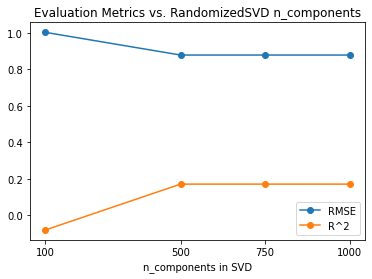

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
def estimate_rating(ratings_input, predicted_ratings, movies, all_rating):
  movie_id = ratings_input.loc['Movie_ID']
  rated_movie_title = movies.loc[movies['Movie_Id'] == movie_id, 'Name'].values[0]
  customer = ratings_input.loc['Customer']
  predicted_rating = predicted_ratings.loc[customer, movie_id]
  return predicted_rating

def evaluate_randomizedSVD(ratings_input, n_components_list, predictions_dict=predictions_dict, movies=movies, all_ratings=df0, 
                pickle_name=None):
  """
  Obtain predicted rating from Randomized SVD and evalutate it using RMSE.
  """
  results = pd.DataFrame()
  rmse = pd.Series(index=n_components_list, dtype='float64')
  r2 = pd.Series(index=n_components_list, dtype='float64')
  for n_components in n_components_list:
    results[f'predicted_{n_components}components'] = ratings_input.transpose().apply(lambda x: estimate_rating(x, 
      predictions_dict[n_components], movies, all_ratings)).transpose()
    rmse.loc[n_components] = mean_squared_error(ratings_input['Rating'], results[f'predicted_{n_components}components'], squared=False)
    r2.loc[n_components] = r2_score(ratings_input['Rating'], results[f'predicted_{n_components}components'])
    print(f'RandomizedSVD with {n_components} components: RMSE {rmse.loc[n_components]}, R^2 {r2.loc[n_components]}')
  results2 = pd.concat([ratings_input[['Customer', 'Movie_ID', 'Rating']], results], axis=1)
  fig, ax = plt.subplots(nrows=1, ncols=1)
  ax.plot(rmse, marker='o', label='RMSE')
  ax.plot(r2, marker='o', label='R^2')
  ax.legend()
  ax.set(xlabel='n_components in SVD', title='Evaluation Metrics vs. RandomizedSVD n_components', xticks=n_components_list)
  # sns.lineplot(y=rmse, ax=ax[0])
  # sns.lineplot(y=r2, ax=ax[1])
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_randomizedSVD_results_df.pickle', 'wb') as fh:
        pickle.dump(results2, fh)
    except:
      print('Unable to save outputs')

  return results2, fig
  
n_components_list = [100, 500, 750, 1000]
results, fig = evaluate_randomizedSVD(df0.sample(100, random_state=0), n_components_list, predictions_dict=predictions_dict)

In [ ]:
fig.savefig('/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/RandomizedSVD_eval_metrics.png')

In [ ]:
results.to_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/RandomizedSVD_test_predictions.csv')

### Look at predictions matrices

In [ ]:
predictions_dict[500]

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,216,217,218,219,220,221,222,223,224,225
Customer,,,,,,,,,,,,,,,,,,,,,
6,3.817880,3.626958,3.709490,2.807774,3.987636,3.152734,2.197370,3.258143,2.689390,3.249060,...,3.286550,3.021279,3.294424,2.671941,3.326256,3.503120,2.674398,4.279529,3.899829,2.800212
7,5.055976,4.865053,4.947586,4.045869,5.225731,4.390829,3.435465,4.496238,3.927485,4.487156,...,4.524645,4.259374,4.532520,3.910036,4.564351,4.741215,3.912493,5.517624,5.137924,4.038308
10,4.151214,3.960291,4.042824,3.141107,4.320969,3.486067,2.530703,3.591476,3.022723,3.582394,...,3.619883,3.354612,3.627758,3.005274,3.659589,3.836453,3.007731,4.612862,4.233162,3.133546
25,3.484547,3.293625,3.376157,2.474441,3.654302,2.819401,1.864036,2.924810,2.356057,2.915727,...,2.953217,2.687945,2.961091,2.338608,2.992923,3.169787,2.341065,3.946196,3.566496,2.466879
33,4.484547,4.293625,4.376157,3.474441,4.654302,3.819401,2.864036,3.924810,3.356057,3.915727,...,3.953217,3.687945,3.961091,3.338608,3.992923,4.169787,3.341065,4.946196,4.566496,3.466879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649401,3.984547,3.793625,3.876157,2.974441,4.154302,3.319401,2.364036,3.424810,2.856057,3.415727,...,3.453217,3.187945,3.461091,2.838608,3.492923,3.669787,2.841065,4.446196,4.066496,2.966879
2649404,4.484547,4.293625,4.376157,3.474441,4.654302,3.819401,2.864036,3.924810,3.356057,3.915727,...,3.953217,3.687945,3.961091,3.338608,3.992923,4.169787,3.341065,4.946196,4.566496,3.466879
2649409,3.984547,3.793625,3.876157,2.974441,4.154302,3.319401,2.364036,3.424810,2.856057,3.415727,...,3.453217,3.187945,3.461091,2.838608,3.492923,3.669787,2.841065,4.446196,4.066496,2.966879


## Visualize predictions

In [ ]:
print(results.columns)
results

Index(['Customer', 'Movie_ID', 'Rating', 'predicted_100components',
       'predicted_500components', 'predicted_750components',
       'predicted_1000components'],
      dtype='object')


,Customer,Movie_ID,Rating,predicted_100components,predicted_500components,predicted_750components,predicted_1000components
284858,2013826,71,2.0,3.260978,3.255023,3.255023,3.255023
974510,762713,223,3.0,4.446097,4.446196,4.446196,4.446196
74606,1879529,28,4.0,5.158185,5.158258,5.158258,5.158258
718703,1886185,191,2.0,3.917183,3.917206,3.917206,3.917206
273212,258937,58,4.0,3.747283,3.747012,3.747012,3.747012
...,...,...,...,...,...,...,...
654879,2312452,175,4.0,4.011535,4.011579,4.011579,4.011579
865475,1470232,197,4.0,3.463910,3.463936,3.463936,3.463936
282179,2032423,68,3.0,3.876831,3.877603,3.877603,3.877603
999448,1702217,225,2.0,1.466315,1.466879,1.466879,1.466879


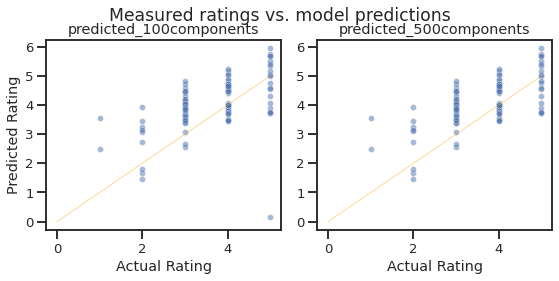

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_predictions(predictions, title='Measured ratings vs. model predictions', 
    context='talk', annotate=True, ymin=-1.5, ymax=10):
  """
  Plot predictions from all the models for a dataset.
      Parameters:
          - predictions (DataFrame): 
              Dataframe that contains target data ('Measured' column) and model predictions
              (1 column per model).
          - title (str): Overall plot title.
          - context (None or str): Seaborn .set_theme() parameter. 
              One of {paper, notebook, talk (default), poster}. If None, set to 'default (notebook)'.
          - annotate (bool): Whether or not to annotate the bar graph with values. Default is True.
      Returns:
          - figure with scatter plots of measured vs. predicted values for all models.

  """
  models = predictions[predictions.columns[~predictions.columns.str.contains('Rating')]].columns.to_list()
  # sns.reset_defaults()    
  # %matplotlib inline
  font_scale=.8 if context=='talk' else 1
  rc={'lines.markersize': 6} if context=='talk' else None
  sns.set_theme(context=context, style='ticks', font_scale=font_scale, 
      rc=rc)
  
  ncols=len(models)
  fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*4, 4))
  ax = ax.flatten()
  for index, model in enumerate(models):
    # Plot measured vs. predicted values for each model
    if index == 0:
        ax[index].set_ylabel('Predicted') 
    sns.lineplot(x=[0,5], y=[0,5], ax=ax[index], linewidth=0.8, color='orange',
        alpha=0.5, legend=False)
    sns.scatterplot(data=predictions, x='Rating', y=model, ax=ax[index],
        alpha=0.5, marker='o', legend=False, 
    ).set(xlabel=None, ylabel=None)
    ax[index].set_title(model)
    if index % ncols == 0:
        ax[index].set_ylabel('Predicted Rating') 
    if index >= len(models) -ncols:
        ax[index].set_xlabel('Actual Rating') 
  fig.suptitle(title)
  fig.tight_layout(rect=[0, 0, 1, 0.98])
  return fig

plot_predictions(results[['Rating', 'predicted_100components', 'predicted_500components']]);

# Perform LogisticRegression using filled utility matrix



In [1]:
import pandas as pd
import numpy as np

def load_csv(filename,filepath,column1_as_index=False,truncate=None, usecols=None, sep=','):
    """
    Load a csv file as a dataframe using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    - colum1_as_index (bool): If true, take the first column as the index. 
        Useful when importing CSV files from previously exported dataframes.

    Returns: dataframe object.
    """
    filename = f'{filepath}/'.replace('\\','/')+filename
    df = pd.read_csv(filename, usecols=usecols, sep=sep)
    if column1_as_index==True:
        df.set_index(df.columns[0], inplace=True)
        df.index.name = None
    print('Dataframe shape: ',df.shape)

    if truncate:
        return df.truncate(after=truncate)
    else:
        return df
        
def create_matrix(df, index='Customer', columns='Movie_ID', values='Rating', pickle_name=None):
  """
  Create a utility matrix. This can then be used for randomizedSVD by converting into csr_matrix
  and filling nan with zero.
  """
  df = df.pivot_table(index=index, columns=columns, values=values)
  
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_sparse_utility_matrix.pickle') as fh:
        pickle.dump(df, fh)
      print(f'Saved: {filepath+pickle_name}_sparse_utility_matrix.pickle')
    except:
      print('Unable to save outputs')
  return df

df0 = load_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/combined_data_reshaped.csv',filepath='',
               column1_as_index=True, truncate=1000000)

Dataframe shape:  (100480507, 4)


In [2]:
df0['Rating'].describe()

count    999776.000000
mean          3.624418
std           1.074985
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: Rating, dtype: float64

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/data exercises/W10/netflix-challenge/movie_titles.csv', header=None, 
    encoding = "ISO-8859-1", # As per https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation
    usecols=[0, 1, 2], # Required because some movie titles (column 2) have commas, causing parser error otherwise
    names=['Movie_Id', 'Year', 'Name'])

## Feature engineering

In [ ]:
import pickle
def create_filled_utility_matrix(df, index='Customer', columns='Movie_ID', values='Rating', pickle_name=None):
  """
  Create a utility matrix where empty values are filled based on the mean for the customer and mean for the movie. This can then be used for randomizedSVD by converting into csr_matrix
  and filling nan with zero.
  """
  print('Original dataframe shape: ', df.shape)
  utility_matrix = df.pivot_table(index=index, columns=columns, values=values)
  print('Utility matrix shape:', utility_matrix.shape)
  # Mean rating in array (nan values excluded)
  mu = utility_matrix.values.reshape(-1)[~np.isnan(utility_matrix.values.reshape(-1))].mean()

  # Array with bias per user. Reshape to be array with same number of rows as customers.
  bu = (utility_matrix.mean(axis=1) - utility_matrix.mean(axis=1).mean()).to_numpy().reshape(-1,1)

  # Array with bias per item. Reshape to be array with same number of columns as movies.
  bi = (utility_matrix.mean() - utility_matrix.mean().mean()).to_numpy().reshape(1,-1)

  predicted_ratings_matrix = (mu + bu + bi + utility_matrix.fillna(0).values) - utility_matrix.fillna(0).values
  predicted_ratings_matrix = pd.DataFrame(predicted_ratings_matrix, 
                                          index=utility_matrix.index, columns=utility_matrix.columns)
  print('Predictions matrix shape:', predicted_ratings_matrix.shape)
  
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_filled_utility_matrix.pickle', 'wb') as fh1:
        pickle.dump(predicted_ratings_matrix, fh1)
      print(f'Saved: {filepath+pickle_name}_filled_utility_matrix.pickle')
    except:
      print('Unable to save outputs')
  return predicted_ratings_matrix

predicted_ratings_matrix2 = create_filled_utility_matrix(df0, pickle_name='LogisticRegression')

Original dataframe shape:  (999776, 4)
Utility matrix shape: (283670, 225)
Predictions matrix shape: (283670, 225)
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/LogisticRegression_filled_utility_matrix.pickle


In [ ]:
import pandas as pd
import numpy as np
import pickle

def loadpickle(filename,filepath='/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'):
    """
    Load a pickled model using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    
    Returns saved object.
    """
    filename = filepath+filename
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model
    
predicted_ratings_matrix2 = loadpickle('/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/LogisticRegression_filled_utility_matrix.pickle', 
                                     filepath='')

In [ ]:
predicted_ratings_matrix2

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,216,217,218,219,220,221,222,223,224,225
Customer,,,,,,,,,,,,,,,,,,,,,
6,3.817880,3.626958,3.709490,2.807774,3.987636,3.152734,2.197370,3.258143,2.689390,3.249060,...,3.286550,3.021279,3.294424,2.671941,3.326256,3.503120,2.674398,4.279529,3.899829,2.800212
7,5.055976,4.865053,4.947586,4.045869,5.225731,4.390829,3.435465,4.496238,3.927485,4.487156,...,4.524645,4.259374,4.532520,3.910036,4.564351,4.741215,3.912493,5.517624,5.137924,4.038308
10,4.151214,3.960291,4.042824,3.141107,4.320969,3.486067,2.530703,3.591476,3.022723,3.582394,...,3.619883,3.354612,3.627758,3.005274,3.659589,3.836453,3.007731,4.612862,4.233162,3.133546
25,3.484547,3.293625,3.376157,2.474441,3.654302,2.819401,1.864036,2.924810,2.356057,2.915727,...,2.953217,2.687945,2.961091,2.338608,2.992923,3.169787,2.341065,3.946196,3.566496,2.466879
33,4.484547,4.293625,4.376157,3.474441,4.654302,3.819401,2.864036,3.924810,3.356057,3.915727,...,3.953217,3.687945,3.961091,3.338608,3.992923,4.169787,3.341065,4.946196,4.566496,3.466879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649401,3.984547,3.793625,3.876157,2.974441,4.154302,3.319401,2.364036,3.424810,2.856057,3.415727,...,3.453217,3.187945,3.461091,2.838608,3.492923,3.669787,2.841065,4.446196,4.066496,2.966879
2649404,4.484547,4.293625,4.376157,3.474441,4.654302,3.819401,2.864036,3.924810,3.356057,3.915727,...,3.953217,3.687945,3.961091,3.338608,3.992923,4.169787,3.341065,4.946196,4.566496,3.466879
2649409,3.984547,3.793625,3.876157,2.974441,4.154302,3.319401,2.364036,3.424810,2.856057,3.415727,...,3.453217,3.187945,3.461091,2.838608,3.492923,3.669787,2.841065,4.446196,4.066496,2.966879


In [ ]:

def estimate_rating(ratings_input, predicted_ratings_matrix, movies):
  """
  Obtain the estimated rating from the filled utility matrix
  """
  # customer_list = predicted_ratings_matrix.index.to_list()
  # movie_list = predicted_ratings_matrix.columns.to_list()
  customer = ratings_input.loc['Customer']
  # customer_index = customer_list[customer_list == customer]
  movie_id = ratings_input.loc['Movie_ID']
  # movie_index = movie_list[movie_list == movie_id]

  rated_movie_title = movies.loc[movies['Movie_Id'] == movie_id, 'Name'].values[0]
  predicted_rating = predicted_ratings_matrix.loc[customer, movie_id]
  return predicted_rating

def batch_estimate_rating(ratings_input, predicted_ratings_matrix=predicted_ratings_matrix2, 
                          movies=movies, pickle_name=None):

  results = ratings_input.transpose().apply(lambda x: estimate_rating(x, 
    predicted_ratings_matrix, movies)).transpose()
  results.name = 'Predicted Rating'
  results2 = pd.concat([ratings_input[['Customer', 'Movie_ID', 'Rating']], results], axis=1)
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_predicted_ratings.pickle', 'wb') as fh1:
        pickle.dump(results2, fh1)
      print(f'Saved: {filepath+pickle_name}_predicted_ratings.pickle')
    except:
      print('Unable to save outputs')
  return results2

results = batch_estimate_rating(df0, pickle_name='average-based')

Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/average-based_predicted_ratings.pickle


In [ ]:
import pickle
import pandas
import numpy as np
def loadpickle(filename,filepath='/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'):
    """
    Load a pickled model using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    
    Returns saved object.
    """
    filename = filepath+filename
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

results = loadpickle('average-based_predicted_ratings.pickle')
results

,Customer,Movie_ID,Rating,Predicted Rating
1,1488844,1,3.0,3.658460
2,822109,1,5.0,5.484547
3,885013,1,4.0,4.770261
4,30878,1,4.0,3.951214
5,823519,1,3.0,4.184547
...,...,...,...,...
999996,528854,225,5.0,4.133546
999997,962705,225,3.0,2.133546
999998,1299323,225,2.0,2.966879
999999,2026970,225,4.0,3.966879


### `run_regression` function

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import ConfusionMatrixDisplay
def run_regression(estimator, results, x_column='Predicted Rating', y_column='Rating', pickle_name=None,
                   context='talk'):
  """
  Fit the data using an estimator and use cross-validation to evaluate.
  """
  sns.reset_defaults()    
  %matplotlib inline
  # if context=='talk':
  #   font_scale=1.4
  # else:
  #   font_scale=1.4
  # print('font',font_scale)
  font_scale=1.4 if context=='talk' else 0.7
  rc={'lines.markersize': 6} if context=='talk' else None
  sns.set_theme(context=context, style='ticks', font_scale=font_scale, 
      rc=rc)
  y = results[y_column]
  X = results[x_column].values.reshape(-1, 1)
  estimator.fit(X, y)
  cv_results =  cross_validate(estimator, X, y, 
      scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
  try:
    r2 = cv_results['test_r2'].mean()
    rmse = abs(cv_results['test_neg_root_mean_squared_error'].mean())
    mae = abs(cv_results['test_neg_mean_absolute_error'].mean())
    results['model_predictions'] = estimator.predict(X)
    print(f'RMSE: {rmse:.2f}')
    print(f'R^2 score: {r2:.4f}')
    print(f'MAE: {mae:.4f}')
  except:
    print('Unable to perform cross-validation')

  # Plot results 
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
  ax = ax.flatten()

  # Plot confusion matrix
  try:
    disp = ConfusionMatrixDisplay.from_predictions(y, results['model_predictions'], ax=ax[2])
    # Plot measured vs. predicted values for each model
    sns.lineplot(x=np.arange(0,5,1), y=np.arange(1,6,1), ax=ax[1], linewidth=0.8, color='orange',
      alpha=0.5) # equality line
    # if (results['model_predictions'] % round(results['model_predictions'])).sum() == 0:
    sns.boxplot(data=results, x=y_column, y='model_predictions', ax=ax[1]).set(
        xlabel='Actual Rating', ylabel='Predicted Rating')
  except:
    sns.violinplot(data=results, x=y_column, y='model_predictions', ax=ax[2]).set(
        xlabel='Actual Rating', ylabel='Predicted Rating')
    sns.lineplot(x=np.arange(0,5,1), y=np.arange(1,6,1), ax=ax[2], linewidth=0.8, color='orange',
      alpha=0.5) # equality line
    sns.histplot(data=results, x='model_predictions', binwidth=1, ax=ax[1], discrete=True)

  fig.suptitle(pickle_name)
  fig.tight_layout(rect=[0, 0, 1, 0.98])

  # Plot histogram of target values
  sns.countplot(x=results['Rating'], ax=ax[0])
  
  # Save outputs
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_model.pickle', 'wb') as fh1:
        pickle.dump(estimator, fh1)
      print(f'Saved: {filepath+pickle_name}_logistic_model.pickle')
      with open(filepath+pickle_name+'_predictions.pickle', 'wb') as fh2:
        pickle.dump(results, fh2)
      print(f'Saved: {filepath+pickle_name}_predictions.pickle')
      fig.savefig(filepath+pickle_name+'_results.png')
      print(f'Saved: {filepath+pickle_name}_results.png')
    except:
      print('Unable to save model')
  return estimator, results

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate_estimate(results, y_pred_column='Predicted Rating', y_column='Rating', pickle_name=None):
  """
  
  """
  y_true = results[y_column]
  y_pred = results[y_pred_column]
  r2 = r2_score(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  mae = mean_absolute_error(y_true, y_pred)

  print(f'RMSE: {rmse:.2f}')
  print(f'R^2 score: {r2:.4f}')
  print(f'MAE: {mae:.4f}')

  # Plot results 
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
  ax = ax.flatten()
  # Plot measured vs. predicted values for each model
  sns.lineplot(x=np.arange(0,5,1), y=np.arange(1,6,1), ax=ax[2], linewidth=0.8, color='orange',
      alpha=0.5)
  sns.violinplot(data=results, x=y_column, y=y_pred_column, ax=ax[2]).set(xlabel='Actual Rating', ylabel='Predicted Rating')
  
  fig.suptitle(pickle_name)
  fig.tight_layout(rect=[0, 0, 1, 0.98])

  # Plot histogram of target values and independent variable
  sns.countplot(x=results['Rating'], ax=ax[0])
  sns.histplot(x=results['Predicted Rating'], binwidth=1, ax=ax[1])
  
  # Save outputs
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      fig.savefig(filepath+pickle_name+'_results.png')
      print(f'Saved: {filepath+pickle_name}_results.png')
    except:
      print('Unable to save figure')


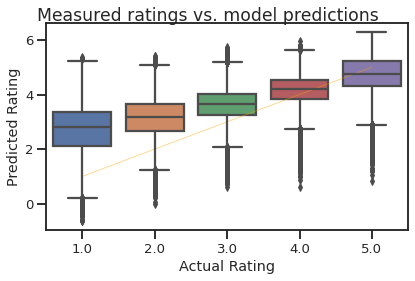

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def predictions_plot(predictions, prediction_column='Predicted Rating', title='Measured ratings vs. model predictions', 
    context='talk', annotate=True, ymin=-1.5, ymax=10):
  """
  Plot predictions from all the models for a dataset.
      Parameters:
          - predictions (DataFrame): 
              Dataframe that contains target data ('Measured' column) and model predictions
              (1 column per model).
          - title (str): Overall plot title.
          - context (None or str): Seaborn .set_theme() parameter. 
              One of {paper, notebook, talk (default), poster}. If None, set to 'default (notebook)'.
          - annotate (bool): Whether or not to annotate the bar graph with values. Default is True.
      Returns:
          - figure with scatter plots of measured vs. predicted values for all models.

  """
  sns.reset_defaults()    
  %matplotlib inline
  font_scale=.8 if context=='talk' else 1
  rc={'lines.markersize': 6} if context=='talk' else None
  sns.set_theme(context=context, style='ticks', font_scale=font_scale, 
      rc=rc)
  
  fig, ax = plt.subplots(nrows=1, ncols=1)
  # Plot measured vs. predicted values for each model
  sns.lineplot(x=np.arange(0,5,1), y=np.arange(1,6,1), ax=ax, linewidth=0.8, color='orange',
      alpha=0.5)
  sns.boxplot(data=predictions, x='Rating', y=prediction_column, ax=ax).set(xlabel=None, ylabel=None)
  ax.set_ylabel('Predicted Rating') 
  ax.set_xlabel('Actual Rating') 
  fig.suptitle(title)
  fig.tight_layout(rect=[0, 0, 1, 0.98])
  return fig
  
predictions_plot(results);

RMSE: 0.88
R^2 score: 0.3335
MAE: 0.6825
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/average-based_results.png


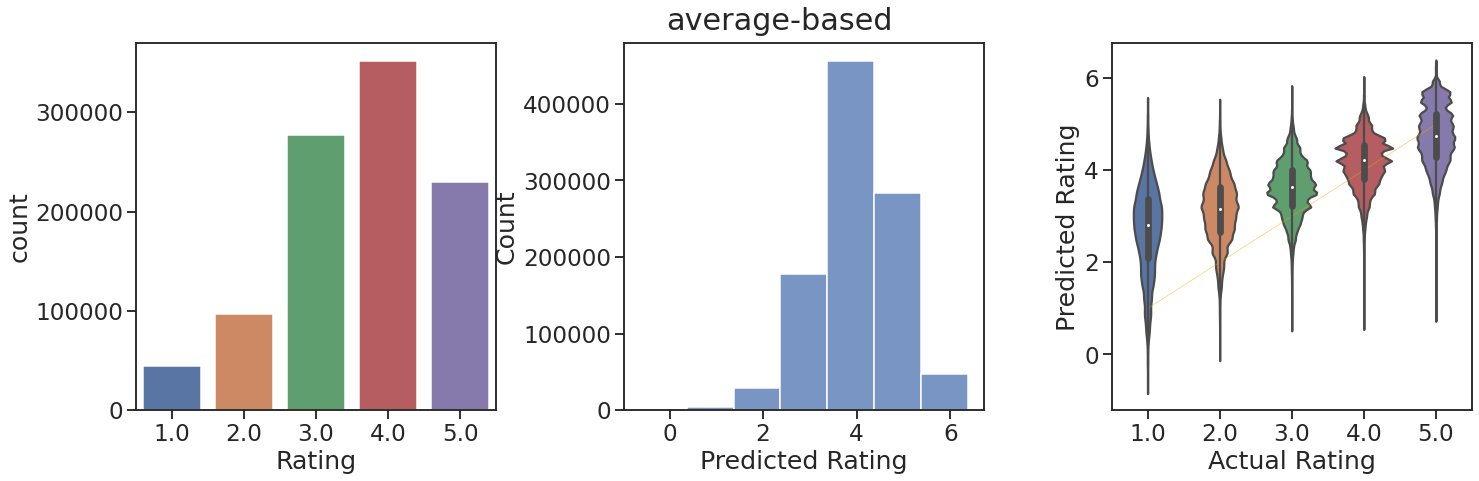

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate_estimate(results, y_pred_column='Predicted Rating', y_column='Rating', pickle_name=None, context='talk'):
  """
  
  """
  sns.reset_defaults()    
  %matplotlib inline
  font_scale=1.4 if context=='talk' else 1
  rc={'lines.markersize': 6} if context=='talk' else None
  sns.set_theme(context=context, style='ticks', font_scale=font_scale, 
      rc=rc)
  y_true = results[y_column]
  y_pred = results[y_pred_column]
  r2 = r2_score(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  mae = mean_absolute_error(y_true, y_pred)

  print(f'RMSE: {rmse:.2f}')
  print(f'R^2 score: {r2:.4f}')
  print(f'MAE: {mae:.4f}')

  # Plot results 
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
  ax = ax.flatten()
  # Plot measured vs. predicted values for each model
  sns.lineplot(x=np.arange(0,5,1), y=np.arange(1,6,1), ax=ax[2], linewidth=0.8, color='orange',
      alpha=0.5)
  sns.violinplot(data=results, x=y_column, y=y_pred_column, ax=ax[2]).set(xlabel='Actual Rating', ylabel='Predicted Rating')
  
  fig.suptitle(pickle_name)
  fig.tight_layout(rect=[0, 0, 1, 0.98])

  # Plot histogram of target values and independent variable
  sns.countplot(x=results['Rating'], ax=ax[0])
  sns.histplot(x=results['Predicted Rating'], binwidth=1, ax=ax[1])
  
  # Save outputs
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      fig.savefig(filepath+pickle_name+'_results.png')
      print(f'Saved: {filepath+pickle_name}_results.png')
    except:
      print('Unable to save figure')

evaluate_estimate(results, pickle_name='average-based');

[Text(0, 0.5, 'Actual Rating'), Text(0.5, 0, 'Predicted Rating')]

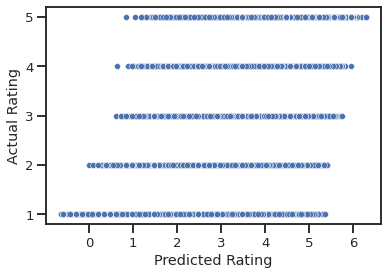

In [ ]:
sns.scatterplot(data=results, x='Predicted Rating', y='Rating').set(ylabel='Actual Rating', xlabel='Predicted Rating')

## Logistic Regression

RMSE: 0.87
R^2 score: 0.3509
MAE: 0.5707
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/logistic_logistic_model.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/logistic_predictions.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/logistic_results.png


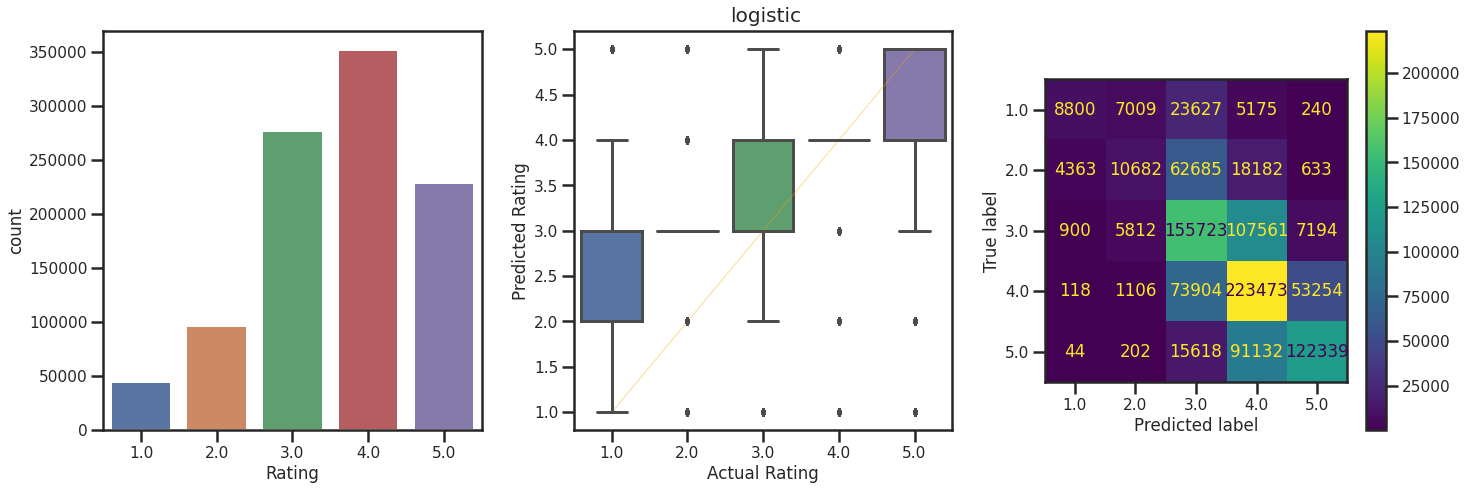

In [ ]:
from sklearn.linear_model import LogisticRegression
clf, results2 = run_regression(LogisticRegression(random_state=0), results, pickle_name='logistic',
  context='poster')
# Tendency to overestimate rating when rating is <4 and underestimate when rating is 5.

In [ ]:
results2

,Customer,Movie_ID,Rating,Predicted Rating,model_predictions
1,1488844,1,3.0,3.658460,3.0
2,822109,1,5.0,5.484547,5.0
3,885013,1,4.0,4.770261,5.0
4,30878,1,4.0,3.951214,4.0
5,823519,1,3.0,4.184547,4.0
...,...,...,...,...,...
999996,528854,225,5.0,4.133546,4.0
999997,962705,225,3.0,2.133546,3.0
999998,1299323,225,2.0,2.966879,3.0
999999,2026970,225,4.0,3.966879,4.0


In [ ]:
(results2['model_predictions'] % round(results2['model_predictions'])).sum()

0.0

In [ ]:
(results2['Predicted Rating'] % round(results2['Predicted Rating'])).sum()

2119138.697028353

In [ ]:
3.2 % round(3.2)

0.20000000000000018

## Ridge Classifier

RMSE: 0.89
R^2 score: 0.3114
MAE: 0.5925
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/ridge_clf_logistic_model.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/ridge_clf_predictions.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/ridge_clf_results.png


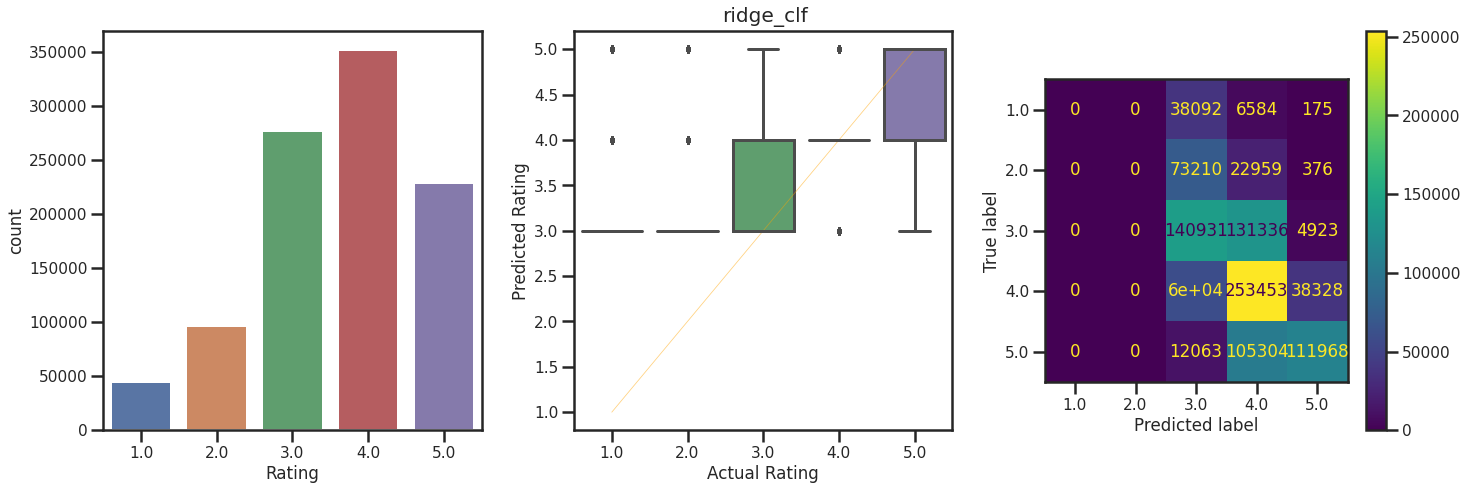

In [ ]:
from sklearn.linear_model import RidgeClassifier
ridge_clf, results3 = run_regression(RidgeClassifier(random_state=0, alpha=0), results, pickle_name='ridge_clf',
                                     context='poster')

In [ ]:
results3

,Customer,Movie_ID,Rating,Predicted Rating,model_predictions
1,1488844,1,3.0,3.658460,3.0
2,822109,1,5.0,5.484547,5.0
3,885013,1,4.0,4.770261,5.0
4,30878,1,4.0,3.951214,4.0
5,823519,1,3.0,4.184547,4.0
...,...,...,...,...,...
999996,528854,225,5.0,4.133546,4.0
999997,962705,225,3.0,2.133546,3.0
999998,1299323,225,2.0,2.966879,3.0
999999,2026970,225,4.0,3.966879,4.0


## Random Forest Classifier

RMSE: 1.18
R^2 score: -0.2235
MAE: 0.8333
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/RandomForest_clf_logistic_model.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/RandomForest_clf_predictions.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/RandomForest_clf_results.png


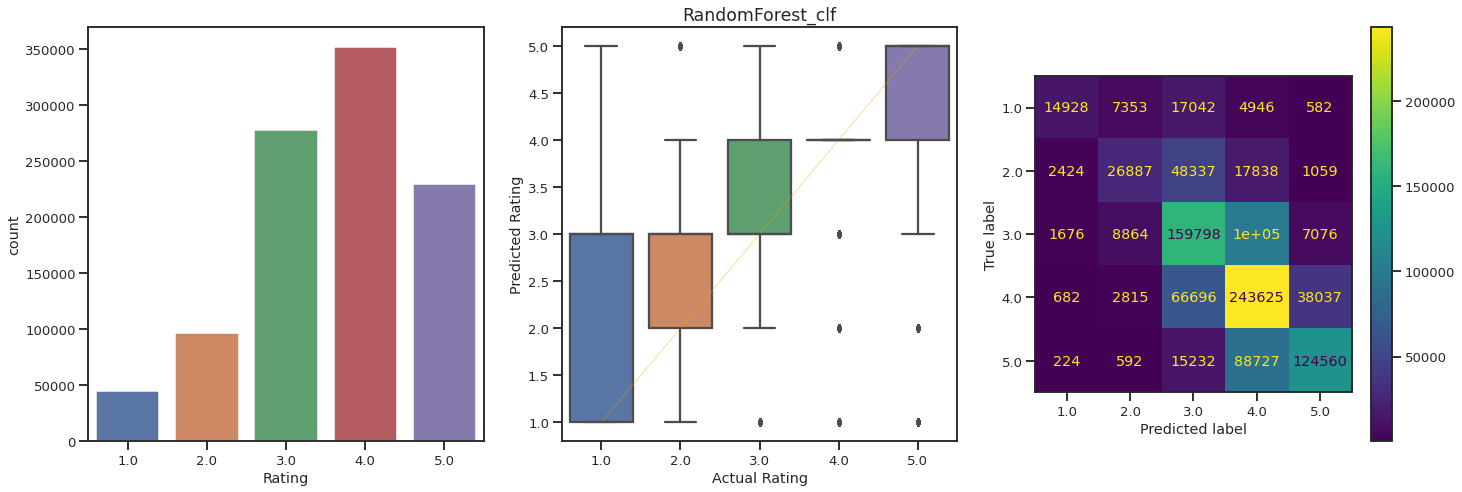

In [ ]:
from sklearn.ensemble import RandomForestClassifier
randomforest_clf, results4 = run_regression(RandomForestClassifier(random_state=0), results, pickle_name='RandomForest_clf')

## [Poisson Regressor](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models)

RMSE: 0.80
R^2 score: 0.4388
MAE: 0.6210
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/Poisson_regressor_logistic_model.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/Poisson_regressor_predictions.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/Poisson_regressor_results.png


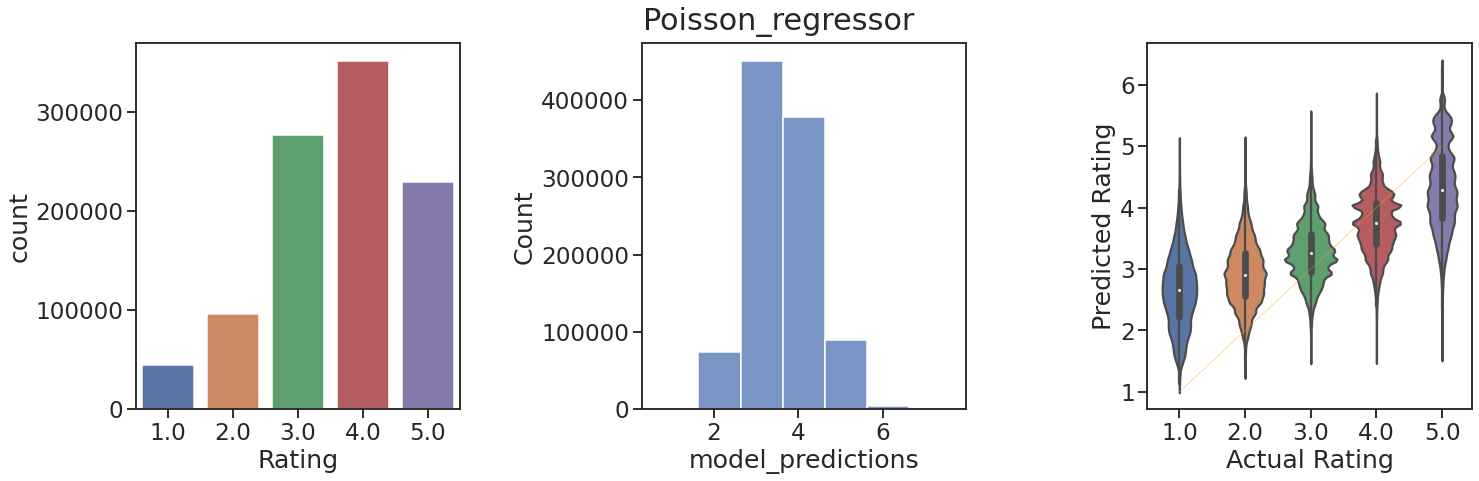

In [ ]:
from sklearn.linear_model import PoissonRegressor
poissonregressor, results5 = run_regression(PoissonRegressor(alpha=0), results, pickle_name='Poisson_regressor')

In [ ]:
results5

,Customer,Movie_ID,Rating,Predicted Rating,model_predictions
1,1488844,1,3.0,3.658460,3.273184
2,822109,1,5.0,5.484547,5.151477
3,885013,1,4.0,4.770261,4.314089
4,30878,1,4.0,3.951214,3.520033
5,823519,1,3.0,4.184547,3.730045
...,...,...,...,...,...
999996,528854,225,5.0,4.133546,3.683096
999997,962705,225,3.0,2.133546,2.241267
999998,1299323,225,2.0,2.966879,2.756619
999999,2026970,225,4.0,3.966879,3.533755


## Linear Regression

In [ ]:
results.head()

,Customer,Movie_ID,Rating,Predicted Rating,model_predictions
1,1488844,1,3.0,3.658460,3.342660
2,822109,1,5.0,5.484547,4.923932
3,885013,1,4.0,4.770261,4.305408
4,30878,1,4.0,3.951214,3.596166
5,823519,1,3.0,4.184547,3.798217


RMSE: 0.79
R^2 score: 0.4515
MAE: 0.6073
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/linear_regressor_logistic_model.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/linear_regressor_predictions.pickle
Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/linear_regressor_results.png


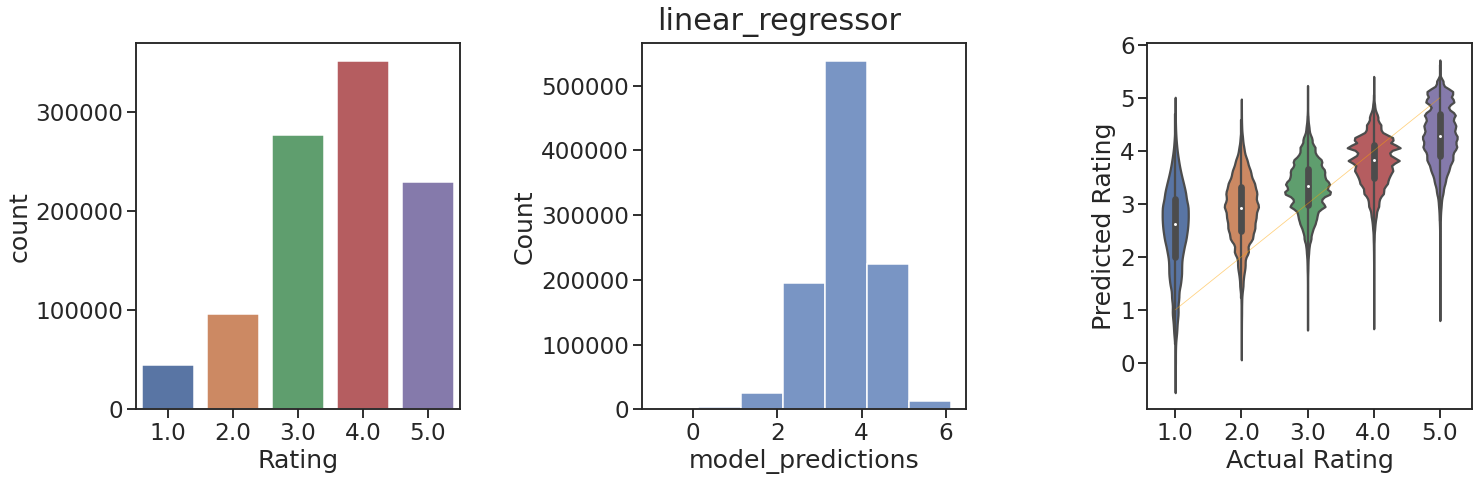

In [ ]:
from sklearn.linear_model import LinearRegression
linearRegressor, results6 = run_regression(LinearRegression(), results, pickle_name='linear_regressor')

### Make recommendations

In [ ]:
def recommend_highest(ratings_input, predicted_ratings_matrix, movies, all_ratings):
  """
  Recommend the movie with the highest predicted rating for that user.
  """
  movie_id = ratings_input.loc['Movie_ID']
  rated_movie_title = movies.loc[movies['Movie_Id'] == movie_id, 'Name'].values[0]
  customer = ratings_input.loc['Customer']
  movie_indices = predicted_ratings_matrix.columns.to_list()
  # try:
  sorted_ratings = predicted_ratings_matrix.loc[customer].argsort()
  highest_rated_indices = sorted_ratings[-5:] # 5 highest ratings
  rated_movies = all_ratings[all_ratings['Customer'] == customer]['Movie_ID'].values
  recommend_movie_id = [movie_indices[highest_index] for highest_index in highest_rated_indices if movie_indices[highest_index] not in rated_movies]
  recommend_title = str(recommend_movie_id[0])+': '+movies[movies['Movie_Id'] == recommend_movie_id[0]]['Name'].values
  return pd.Series([rated_movie_title, recommend_title], index=['Rated Movie', 'Recommended Movie'])
  # except: 
  #   return pd.Series([rated_movie_title, None], index=['Rated Movie', 'Recommended Movie'])


def batch_recommend_highest(ratings_input, predicted_ratings_matrix=predicted_ratings_matrix2, movies=movies, 
                            all_ratings=df0):
  """
  Recommend one movie.
  Parameters:
    - ratings_df: DataFrame containing Customers and their movie ratings.

  Returns:
    - DataFrame containing a single new movie recommendation for each customer.
  """
  results = ratings_input.transpose().apply(lambda x: recommend_highest(x, 
    predicted_ratings_matrix, movies, all_ratings)).transpose()
  recommendations = pd.concat([ratings_input['Customer'], results], axis=1)
  print(f"**Input movies count**: {len(recommendations['Rated Movie'].value_counts())}\n{recommendations['Rated Movie'].value_counts()}")
  print(f"\n**Recommended movies count**: {len(recommendations['Recommended Movie'].value_counts())}\n{recommendations['Recommended Movie'].value_counts()}")
  print(f"\n**No recommendations count**: {recommendations['Recommended Movie'].isna().sum()}")

  return recommendations

batch_recommend_highest(df0.sample(5, random_state=0))

**Input movies count**: 5
Maya Lin: A Strong Clear Vision    1
Chappelle's Show: Season 1         1
Lilo and Stitch                    1
X2: X-Men United                   1
Dragonheart                        1
Name: Rated Movie, dtype: int64

**Recommended movies count**: 1
[209: Star Trek: Deep Space Nine: Season 5]    5
Name: Recommended Movie, dtype: int64

**No recommendations count**: 0


,Customer,Rated Movie,Recommended Movie
284858,2013826,Maya Lin: A Strong Clear Vision,[209: Star Trek: Deep Space Nine: Season 5]
974510,762713,Chappelle's Show: Season 1,[209: Star Trek: Deep Space Nine: Season 5]
74606,1879529,Lilo and Stitch,[209: Star Trek: Deep Space Nine: Season 5]
718703,1886185,X2: X-Men United,[209: Star Trek: Deep Space Nine: Season 5]
273212,258937,Dragonheart,[209: Star Trek: Deep Space Nine: Season 5]


In [ ]:
batch_recommend_highest(df0.sample(100, random_state=0))

**Input movies count**: 31
Something's Gotta Give                     16
Reservoir Dogs                             16
X2: X-Men United                           12
Taking Lives                                9
Lilo and Stitch                             6
Chappelle's Show: Season 1                  4
Sweet November                              4
Duplex (Widescreen)                         3
Dragonheart                                 3
The Game                                    3
Congo                                       2
Death to Smoochy                            2
Richard III                                 2
A Little Princess                           1
That '70s Show: Season 1                    1
Richard Pryor: Live on the Sunset Strip     1
Spartan                                     1
Rudolph the Red-Nosed Reindeer              1
Rambo: First Blood Part II                  1
Invader Zim                                 1
G3: Live in Concert                         1
Maya Li

,Customer,Rated Movie,Recommended Movie
284858,2013826,Maya Lin: A Strong Clear Vision,[209: Star Trek: Deep Space Nine: Season 5]
974510,762713,Chappelle's Show: Season 1,[209: Star Trek: Deep Space Nine: Season 5]
74606,1879529,Lilo and Stitch,[209: Star Trek: Deep Space Nine: Season 5]
718703,1886185,X2: X-Men United,[209: Star Trek: Deep Space Nine: Season 5]
273212,258937,Dragonheart,[209: Star Trek: Deep Space Nine: Season 5]
...,...,...,...
654879,2312452,Reservoir Dogs,[209: Star Trek: Deep Space Nine: Season 5]
865475,1470232,Taking Lives,[209: Star Trek: Deep Space Nine: Season 5]
282179,2032423,Invader Zim,[209: Star Trek: Deep Space Nine: Season 5]
999448,1702217,The Cookout,[209: Star Trek: Deep Space Nine: Season 5]


# Compile results

In [18]:
results = load_csv('compiled_results2.csv', filepath=r'/content/drive/MyDrive/data exercises/W10/netflix-challenge/',
               column1_as_index=True)
results['recommended to input ratio']  = results['Number of recommended movies based on test sample*']/results['Number of movies in test sample*']
results=results[:3].copy()
results

Dataframe shape:  (8, 3)


,Number of samples used in training,Number of movies in test sample*,Number of recommended movies based on test sample*,recommended to input ratio
Surprise NMF,"100,480,507",31.0,28.0,0.903226
Surprise SVD,"100,480,507",31.0,16.0,0.516129
Linear Regression,"1,000,000",31.0,3.0,0.096774


In [19]:
print(f'. | ', end='')
for values in results.columns.to_list():
  print(f'{values} | ', end='')
print('')
for values in results.columns.to_list():
  print(f'--- | ', end='')
print('--- |')
for values in results.itertuples():
  print(f'{values[0]} | {values[1]} | {values[2]} | {values[3]} | {values[4]:.2f}')

. | Number of samples used in training | Number of movies in test sample* | Number of recommended movies based on test sample* | recommended to input ratio | 
--- | --- | --- | --- | --- |
Surprise NMF | 100,480,507 | 31.0 | 28.0 | 0.90
Surprise SVD | 100,480,507 | 31.0 | 16.0 | 0.52
Linear Regression | 1,000,000 | 31.0 | 3.0 | 0.10


[Text(0.5, 1.0, 'Scikit Surprise NMF algorithm resulted in highest ratio')]

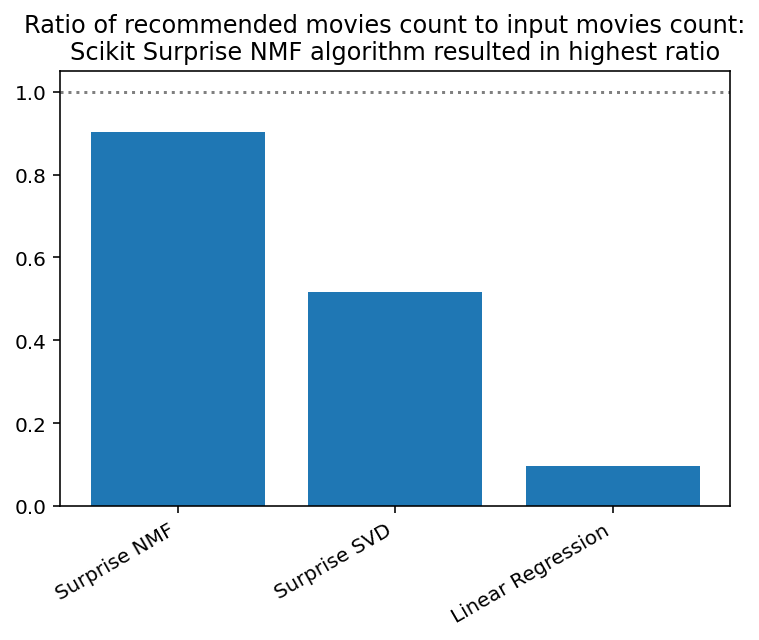

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['savefig.dpi'] = 100
fig, ax = plt.subplots()

ax.axhline(y=1, ls=':', color='grey')
ax.bar(x=results['recommended to input ratio'].index, height=results['recommended to input ratio'].values)
plt.xticks(rotation=30, ha='right')
fig.suptitle('Ratio of recommended movies count to input movies count:')
ax.set(title='Scikit Surprise NMF algorithm resulted in highest ratio')

In [22]:
fig.savefig('/content/drive/MyDrive/data exercises/W10/netflix-challenge/Exp2_recommendations_barchart.png', bbox_inches='tight')

# Use multiple features:
* Mean rating of the customer
* Mean rating for that movie

In [ ]:
import pickle
def create_matrix(df, index='Customer', columns='Movie_ID', values='Rating', pickle_name=None):
  """
  Create a utility matrix. This can then be used for randomizedSVD by converting into csr_matrix
  and filling nan with zero.
  """
  df = df.pivot_table(index=index, columns=columns, values=values)
  
  if pickle_name:
    try:
      filepath = '/content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/'
      with open(filepath+pickle_name+'_sparse_utility_matrix.pickle', 'wb') as fh:
        pickle.dump(df, fh)
      print(f'Saved: {filepath+pickle_name}_sparse_utility_matrix.pickle')
    except:
      print('Unable to save outputs')
  return df

utility_matrix = create_matrix(df0, pickle_name='1000000_samples')

Saved: /content/drive/MyDrive/data exercises/W10/netflix-challenge/saved_models/1000000_samples_sparse_utility_matrix.pickle


In [ ]:
utility_matrix

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,216,217,218,219,220,221,222,223,224,225
Customer,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
